Data Collection Script for Instagram API

Overview

This script demonstrates how to collect data from the Instagram API using the RapidAPI service. It retrieves basic influencer activity data such as posts and follower information.

Prerequisites





RapidAPI account and API key



Python environment with requests library installed

In [ ]:
%pip install pandas scikit-learn matplotlib seaborn textblob nltk python-louvain streamlit python-dotenv


In [ ]:
from dotenv import load_dotenv
import os
import requests
import json
import pandas as pd
import time
from requests.exceptions import HTTPError

load_dotenv()
BASE_URL = "https://twitter241.p.rapidapi.com"
HEADERS = {
    "x-rapidapi-host": os.getenv("RAPIDAPI_HOST"),
    "x-rapidapi-key": os.getenv("RAPIDAPI_KEY")
}

INFLUENCER_USERNAMES = [
    "Ninja",            # Tyler Blevins
    "shroud",           # Michael Grzesiek
    "Myth_",            # Ali Kabbani
    "DrLupo",           # Benjamin Lupo
    "TimTheTatman",     # Tim Betar
    "Syndicate",        # Tom Cassell
    "Summit1g",         # Jaryd Lazar
    "Pokimane",         # Imane Anys
    "Tfue",             # Turner Tenney
    "Jacksepticeye",    # Seán McLoughlin
    "Valkyrae",         # Rachell Hofstetter
    "Quackity",         # Alexis
    "TheGrefg",         # David Cánovas Martínez
    "Jynxzi",           # Nicholas Stewart
    "markiplier",       # Mark Fischbach
    "SSSniperWolf",     # Alia Shelesh
    "OMGitsAliA",       # Alastair Aiken
    "scump",            # Seth Abner
    "LazarBeam",        # Lannan Eacott
    "Pokelawls",        # Georgie
]

def retry_on_429(max_retries=5, backoff_factor=2, initial_delay=1):
    def decorator(func):
        def wrapper(*args, **kwargs):
            retries = 0
            delay = initial_delay
            while retries <= max_retries:
                try:
                    result = func(*args, **kwargs)
                    return result
                except HTTPError as e:
                    if e.response.status_code == 429:
                        print(f"429 Too Many Requests error encountered. Retry {retries + 1} in {delay} seconds...")
                        time.sleep(delay)
                        retries += 1
                        delay *= backoff_factor
                    else:
                        raise
            print(f"Max retries reached for function {func.__name__}. Skipping...")
            return None
        return wrapper
    return decorator

@retry_on_429()
def get_user_info(username):
    url = f"{BASE_URL}/user"
    params = {"username": username}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_followers(user_id, count=100):
    url = f"{BASE_URL}/followers"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_following(user_id, count=100):
    url = f"{BASE_URL}/followings"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_tweets(user_id, count=50):
    url = f"{BASE_URL}/user-tweets"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()


influencer_data = []
followers_data = []
following_data = []
tweets_data = []

for username in INFLUENCER_USERNAMES:
    print(f"Collecting data for {username}...")

    user_info = get_user_info(username)
    if user_info:
        influencer_data.append(user_info)
        user_id = user_info.get("result", {}).get("data", {}).get("user", {}).get("result", {}).get("rest_id")

        if user_id:
            print(user_id)

            followers = get_user_followers(user_id)
            if followers:
                followers_data.append({
                    "user_id": user_id,
                    "username": username,
                    "followers": followers
                })

            following = get_user_following(user_id)
            if following:
                following_data.append({
                    "user_id": user_id,
                    "username": username,
                    "following": following
                })

            tweets = get_user_tweets(user_id)
            if tweets:
                tweets_data.append({
                    "user_id": user_id,
                    "username": username,
                    "tweets": tweets
                })
        else:
            print('User ID not found for', username)

    # Small delay between users to reduce rate limiting chance
    time.sleep(1)

# Save data
with open('data/raw/influencer_profiles.json', 'w') as f:
    json.dump(influencer_data, f)

with open('data/raw/followers_data.json', 'w') as f:
    json.dump(followers_data, f)

with open('data/raw/following_data.json', 'w') as f:
    json.dump(following_data, f)

with open('data/raw/tweets_data.json', 'w') as f:
    json.dump(tweets_data, f)

print("Data collection completed and saved to JSON files!")


In [ ]:
# Task 2: Social Network Construction (Real Data)
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd

# Load the collected data
with open('data/raw/influencer_profiles.json', 'r') as f:
    influencer_profiles = json.load(f)

with open('data/raw/following_data.json', 'r') as f:
    following_data = json.load(f)

# Create a directed graph
G = nx.DiGraph()

# Store influencer nodes with their metadata
influencer_nodes = []
user_id_map = {}  # screen_name.lower() → user_id
screen_name_map = {}  # user_id → screen_name.lower()

# Add influencer nodes to graph
for profile in influencer_profiles:
    try:
        user_data = profile['result']['data']['user']['result']
        user_id = user_data['rest_id']
        screen_name = user_data['legacy']['screen_name']
        name = user_data['legacy']['name']
        followers_count = user_data['legacy']['followers_count']
        friends_count = user_data['legacy']['friends_count']
        statuses_count = user_data['legacy']['statuses_count']

        G.add_node(user_id,
                   screen_name=screen_name,
                   name=name,
                   followers_count=followers_count,
                   friends_count=friends_count,
                   statuses_count=statuses_count,
                   is_influencer=True)

        influencer_nodes.append({
            'user_id': user_id,
            'screen_name': screen_name,
            'name': name,
            'followers_count': followers_count,
            'friends_count': friends_count,
            'statuses_count': statuses_count
        })

        user_id_map[screen_name.lower()] = user_id
        screen_name_map[user_id] = screen_name.lower()

    except (KeyError, TypeError) as e:
        print(f"Error processing profile: {e}")

# Convert to DataFrame for analysis
influencer_df = pd.DataFrame(influencer_nodes)

# Extract real following relationships to build edges
def extract_following_ids(entries):
    user_ids = set()
    for entry in entries:
        try:
            content = entry['content']['itemContent']
            followed_id = content['user_results']['result']['rest_id']
            user_ids.add(followed_id)
        except (KeyError, TypeError):
            continue
    return user_ids

# Create edges: source → target if source follows target and both are influencers
influencer_ids = set(screen_name_map.keys())

for item in following_data:
    source_id = item['user_id']
    instructions = item.get('following', {}).get('result', {}).get('timeline', {}).get('instructions', [])

    # Find the 'TimelineAddEntries' section with actual data
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            followed_ids = extract_following_ids(entries)

            for target_id in followed_ids:
                if target_id in influencer_ids:
                    G.add_edge(source_id, target_id, weight=1)

# Visualize the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
node_sizes = [G.nodes[n]['followers_count'] / 1_000_000 for n in G.nodes()]
nx.draw_networkx_nodes(G, pos,
                       node_size=[max(5, size * 20) for size in node_sizes],
                       node_color='skyblue',
                       alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Draw labels
labels = {node: G.nodes[node]['screen_name'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Social Network of Top Influencers")
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_network.png', dpi=300)
plt.show()
plt.close()

# Save the graph
nx.write_gexf(G, 'data/processed/influencer_network.gexf')

# Display stats
print("Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Display influencer info
print("\nInfluencer Summary:")
print(influencer_df[['name', 'screen_name', 'followers_count']].sort_values(by='followers_count', ascending=False))

print("\nSocial network construction (real data) completed!")


In [ ]:
# Task 3: Social Network Analysis
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the influencer network graph
G = nx.read_gexf('data/processed/influencer_network.gexf')

# === 1. CENTRALITY ANALYSIS ===
# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'user_id': list(G.nodes()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values()),
    'pagerank': list(pagerank.values())
})

# Add influencer attributes from the graph
for i, node in enumerate(centrality_df['user_id']):
    centrality_df.loc[i, 'name'] = G.nodes[node]['name']
    centrality_df.loc[i, 'screen_name'] = G.nodes[node]['screen_name']
    centrality_df.loc[i, 'followers_count'] = float(G.nodes[node]['followers_count'])
    centrality_df.loc[i, 'friends_count'] = float(G.nodes[node]['friends_count'])
    centrality_df.loc[i, 'statuses_count'] = float(G.nodes[node]['statuses_count'])

# === 2. INFLUENCER SCORE ===
# Normalize centrality + followers data
scaler = StandardScaler()
features = ['degree_centrality', 'betweenness_centrality', 
            'closeness_centrality', 'eigenvector_centrality', 
            'pagerank', 'followers_count']
scaled_centrality = scaler.fit_transform(centrality_df[features])

# Weighted score
weights = [0.15, 0.10, 0.10, 0.25, 0.15, 0.25]
influencer_scores = np.dot(scaled_centrality, np.array(weights))
centrality_df['influencer_score'] = influencer_scores

# === 3. COMMUNITY DETECTION BASED ON GRAPH STRUCTURE ===
try:
    import community as community_louvain  # Make sure you have 'python-louvain' installed
except ImportError:
    raise ImportError("Please install it via pip: pip install python-louvain")

# Convert to undirected for better community detection
G_undirected = G.to_undirected()

# Run Louvain algorithm on the graph (structure-based)
partition = community_louvain.best_partition(G_undirected, resolution=1.0)

# Map communities back to the DataFrame
centrality_df['community'] = centrality_df['user_id'].map(partition)

# Assign community as node attribute in graph
nx.set_node_attributes(G, partition, 'community')

print("Community detection based on network structure (Louvain) completed.")


# === 4. ANALYSIS OUTPUT ===
# Save centrality metrics and scores
centrality_df.to_csv('data/outputs/centrality/influencer_centrality.csv', index=False)

# === 5. VISUALIZATIONS ===
# Network with influencer score + community
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
node_sizes = [(score + abs(min(influencer_scores)) + 1) * 2000 for score in influencer_scores]
node_colors = [centrality_df.loc[centrality_df['user_id'] == node, 'community'].values[0] for node in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7, cmap=plt.cm.Set2)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={node: centrality_df.loc[centrality_df['user_id'] == node, 'screen_name'].values[0] for node in G.nodes()}, font_size=10)
plt.title("Influencer Network - Centrality & Community", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_analysis_network.png', dpi=300)
plt.show()
plt.close()

# Centrality bar comparison
plt.figure(figsize=(14, 8))
measure_cols = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
colors = sns.color_palette("husl", len(measure_cols))
sorted_df = centrality_df.sort_values('influencer_score', ascending=False)
x = np.arange(len(sorted_df))
width = 0.15

for i, column in enumerate(measure_cols):
    plt.bar(x + i*width, sorted_df[column], width, label=column, color=colors[i])

plt.xlabel('Influencers', fontsize=12)
plt.ylabel('Centrality Value', fontsize=12)
plt.title('Centrality Comparison by Influencer', fontsize=16)
plt.xticks(x + width*2, sorted_df['screen_name'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/centrality_comparison.png', dpi=300)
plt.show()
plt.close()

# Followers vs Influencer Score
plt.figure(figsize=(10, 8))
sns.scatterplot(x='followers_count', y='influencer_score',
                hue='community', size='pagerank', sizes=(100, 1000),
                data=centrality_df, palette='Spectral')

for i, row in centrality_df.iterrows():
    plt.annotate(row['screen_name'], (row['followers_count'], row['influencer_score']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title("Followers vs Influencer Score", fontsize=16)
plt.xlabel("Followers Count", fontsize=12)
plt.ylabel("Influencer Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/followers_vs_score.png', dpi=300)
plt.show()
plt.close()

# === 6. OUTPUT TOP INFLUENCERS AND COMMUNITY STATS ===
print("Top 5 Influencers Based on Composite Score:")
print(centrality_df[['name', 'screen_name', 'followers_count', 'influencer_score']].sort_values(by='influencer_score', ascending=False).head(5))

# print("\nCommunity Group Summary (mean influencer score per group):")
# print(centrality_df.groupby('community')['influencer_score'].mean().reset_index().sort_values(by='influencer_score', ascending=False))

print("\nSocial network analysis completed!")

print("\nTop influencers in each community based on influencer score:")
for comm_id in sorted(centrality_df['community'].unique()):
    print(f"\nCommunity {comm_id}:")
    top_group = centrality_df[centrality_df['community'] == comm_id].sort_values("influencer_score", ascending=False).head(3)
    print(top_group[['screen_name', 'followers_count', 'influencer_score']])
    
num_communities = len(set(partition.values()))
print(f"\nTotal communities detected: {num_communities}")




## DRAFT

In [ ]:
%pip install xgboost

[nltk_data] Downloading package punkt to /Users/wenghong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wenghong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wenghong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tweet ID: 1928195929758199853, Created At: 2025-05-29 21:05:08+00:00
Tweet ID: 1927432757589787010, Created At: 2025-05-27 18:32:34+00:00
Tweet ID: 1927020233111335298, Created At: 2025-05-26 15:13:20+00:00
Tweet ID: 1926669579511607598, Created At: 2025-05-25 15:59:58+00:00
Tweet ID: 1925983918160789895, Created At: 2025-05-23 18:35:23+00:00
Skipping entry without 'itemContent': {'entryType': 'TimelineTimelineModule', '__typename': 'TimelineTimelineModule', 'items': [{'entryId': 'who-to-follow-1929848380356296709-user-425871040', 'item': {'itemContent': {'itemType': 'TimelineUser', '__typename': 'TimelineUser', 'user_results': {'result': {'__typename': 'User', 'id': 'VXNlcjo0MjU4NzEwNDA=', 'rest_id': '425871040', 'affiliates_highlighted_label': {}, 'has_graduated_access': True, 'is_blue_verified': False, 'profile_image_shape': 'Square', 'legacy': {'can_dm': False, 'can_media_tag': True, 'created_at': 'Thu Dec 01 14:57:32 +0000 2011', 'default_profile': False, 'default_profile_image': 

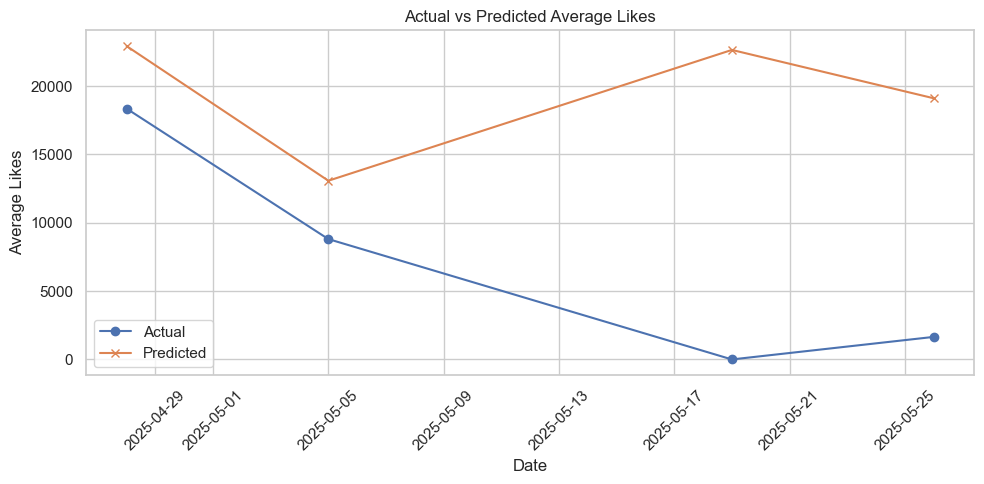

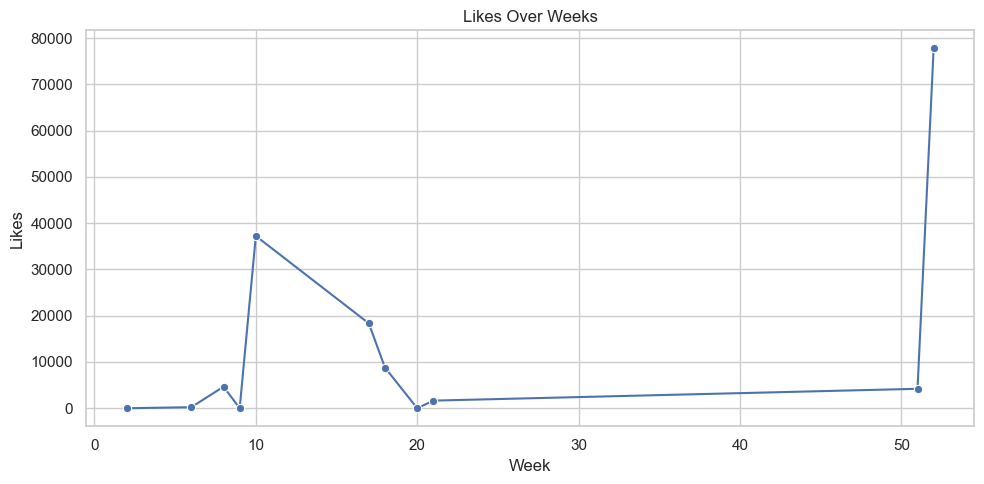

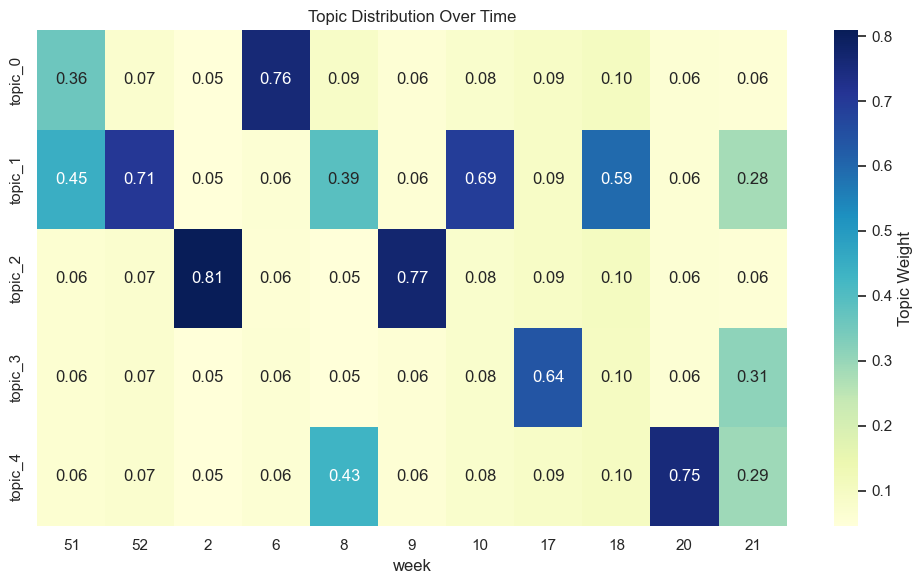

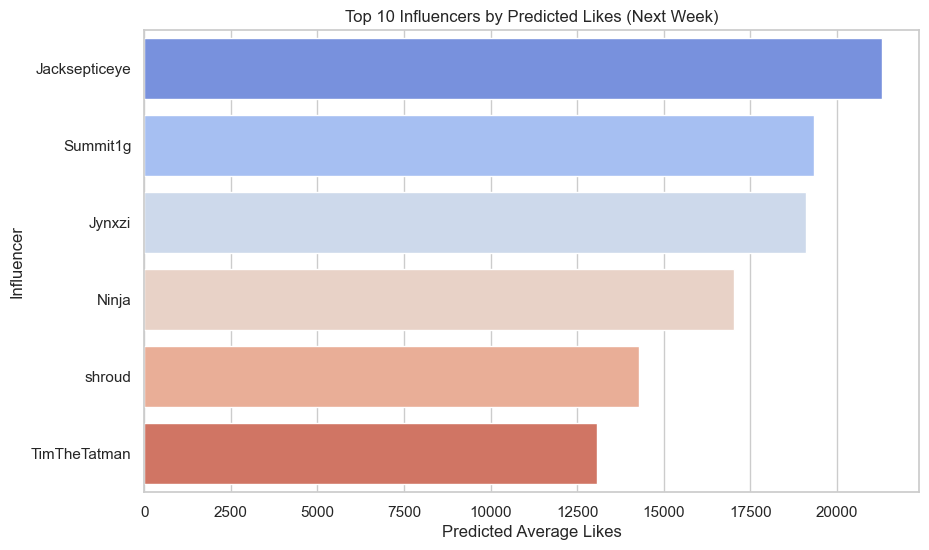

<Figure size 1000x600 with 0 Axes>

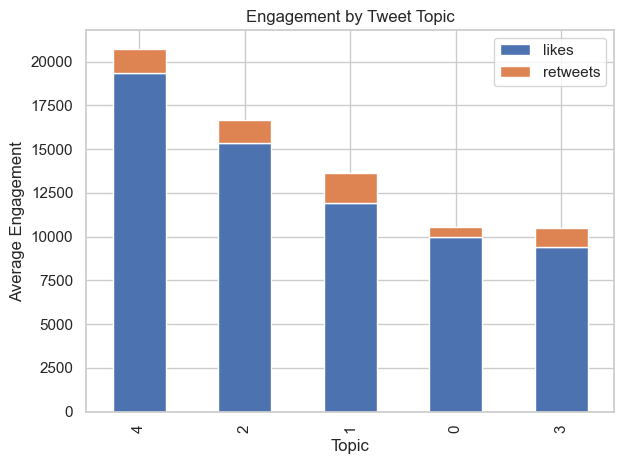

2025-06-04 13:10:57.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:57.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar


🗂 Top Keywords per Topic:
Topic 0: bxtd6meqh3, gta, chillin, rt, going, twitch, youtube, summit1g, live, https
Topic 1: optic, rt, night, stream, gonna, day, live, good, today, https
Topic 2: tomorrow, verdansk, work, safe, d7tqjildgj, fortnite, live, thank, rt, https
Topic 3: raiders, hwqufo0uxu, fortnite, love, live, day, en, time, rt, https
Topic 4: friend, 10, football, lt, running, live, ll, just, rt, https
Error: 'user_id' column not found in influencer_profiles
MSE: 278435608.3436, MAE: 14793.9520, R²: -0.6150


2025-06-04 13:10:58.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 13:10:58.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [30]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# --- Step 1: Load and Prepare Data ---
data_dir = "data/raw/"

# Load influencer profiles from JSON
try:
    with open(os.path.join(data_dir, "influencer_profiles.json"), "r") as f:
        influencer_profiles = json.load(f)
except FileNotFoundError:
    print(f"Error: influencer_profiles.json not found in {data_dir}")
    influencer_profiles = []
except json.JSONDecodeError:
    print(f"Error: influencer_profiles.json contains invalid JSON")
    influencer_profiles = []

# Load tweets data from JSON
try:
    with open(os.path.join(data_dir, "tweets_data.json"), "r") as f:
        tweets_data = json.load(f)
except FileNotFoundError:
    print(f"Error: tweets_data.json not found in {data_dir}")
    tweets_data = []
except json.JSONDecodeError:
    print(f"Error: tweets_data.json contains invalid JSON")
    tweets_data = []

# Load followers data from JSON
try:
    with open(os.path.join(data_dir, "followers_data.json"), "r") as f:
        followers_data = json.load(f)
except FileNotFoundError:
    print(f"Error: followers_data.json not found in {data_dir}")
    followers_data = []
except json.JSONDecodeError:
    print(f"Error: followers_data.json contains invalid JSON")
    followers_data = []

# Load following data from JSON
try:
    with open(os.path.join(data_dir, "following_data.json"), "r") as f:
        following_data = json.load(f)
except FileNotFoundError:
    print(f"Error: following_data.json not found in {data_dir}")
    following_data = []
except json.JSONDecodeError:
    print(f"Error: following_data.json contains invalid JSON")
    following_data = []

# Load centrality metrics from CSV
try:
    centrality_data = pd.read_csv("data/outputs/centrality/influencer_centrality.csv")
except FileNotFoundError:
    print(f"Error: influencer_centrality.csv not found in data/outputs/centrality")
    centrality_data = pd.DataFrame()

# --- Step 2: Process Tweets Data ---
tweets_list = []
for user in tweets_data:
    user_id = user.get("user_id", "")
    username = user.get("username", "")
    try:
        entries = user["tweets"]["result"]["timeline"]["instructions"][1]["entries"]
    except (KeyError, IndexError) as e:
        print(f"Error accessing entries for user {username}: {e}")
        continue

    for entry in entries:
        if "itemContent" in entry["content"]:
            try:
                tweet = entry["content"]["itemContent"]["tweet_results"]["result"]["legacy"]
                tweet_id = entry["content"]["itemContent"]["tweet_results"]["result"]["rest_id"]
                created_at = datetime.strptime(tweet["created_at"], "%a %b %d %H:%M:%S %z %Y")
                text = tweet["full_text"]
                likes = tweet["favorite_count"]
                retweets = tweet["retweet_count"]
                comments = tweet["reply_count"]
                views = int(entry["content"]["itemContent"]["tweet_results"]["result"]["views"].get("count", 0))
                has_media = "media" in tweet.get("entities", {}) and len(tweet["entities"]["media"]) > 0

                tweets_list.append({
                    "user_id": user_id,
                    "username": username,
                    "tweet_id": tweet_id,
                    "created_at": created_at,
                    "text": text,
                    "likes": likes,
                    "retweets": retweets,
                    "comments": comments,
                    "views": views,
                    "has_media": has_media
                })
                print(f"Tweet ID: {tweet_id}, Created At: {created_at}")
            except (KeyError, ValueError) as e:
                print(f"KeyError: {e} - Skipping entry with unexpected structure: {entry['content']}")
        else:
            print(f"Skipping entry without 'itemContent': {entry['content']}")

tweets_df = pd.DataFrame(tweets_list)

# Extract temporal features
tweets_df["week"] = tweets_df["created_at"].dt.isocalendar().week
tweets_df["year"] = tweets_df["created_at"].dt.year
tweets_df["posting_hour"] = tweets_df["created_at"].dt.hour
tweets_df["day_of_week"] = tweets_df["created_at"].dt.dayofweek

# --- Step 3: Text Preprocessing and Feature Extraction ---
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

tweets_df["processed_text"] = tweets_df["text"].apply(preprocess_text)

# Sentiment analysis
tweets_df["sentiment"] = tweets_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Topic modeling with LDA
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_df["processed_text"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
topic_cols = [f"topic_{i}" for i in range(5)]
tweets_df[topic_cols] = lda_topics

# ---------------------------------------
# PART E: Topic Modeling & Engagement
# ---------------------------------------
with open('data/raw/tweets_data.json', 'r') as f:
    tweets = json.load(f)

rows = []
for user in tweets:
    instructions = user.get('tweets', {}).get('result', {}).get('timeline', {}).get('instructions', [])
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            for entry in entries:
                content = entry.get('content', {})
                item_content = content.get('itemContent', {})
                tweet_result = item_content.get('tweet_results', {}).get('result', {})
                legacy = tweet_result.get('legacy', {})
                text = legacy.get('full_text', "")
                timestamp = legacy.get('created_at', None)
                if text and timestamp:
                    try:
                        dt = datetime.strptime(timestamp, '%a %b %d %H:%M:%S %z %Y')
                        rows.append({
                            'text': text,
                            'hour': dt.hour,
                            'likes': legacy.get('favorite_count', 0),
                            'retweets': legacy.get('retweet_count', 0)
                        })
                    except Exception as e:
                        print(f"Skipping tweet due to error: {e}")

df_tweets = pd.DataFrame(rows)
print(f"✅ Loaded {len(df_tweets)} tweets with timestamps.")

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_topics = vectorizer.fit_transform(df_tweets['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_topics)

df_tweets['topic'] = lda.transform(X_topics).argmax(axis=1)
topic_engagement = df_tweets.groupby('topic')[['likes', 'retweets']].mean().sort_values(by='likes', ascending=False)

plt.figure(figsize=(10, 6))
topic_engagement.plot(kind='bar', stacked=True)
plt.title("Engagement by Tweet Topic")
plt.xlabel("Topic")
plt.ylabel("Average Engagement")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_topic.png", dpi=300)
plt.show()

print("\n🗂 Top Keywords per Topic:")
for idx, topic in enumerate(lda.components_):
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx}: {', '.join(top_keywords)}")

# --- Step 4: Aggregate Weekly Metrics ---
# Include user_id in groupby to preserve it
weekly_metrics = tweets_df.groupby(["user_id", "username", "year", "week"]).agg({
    "likes": "mean",
    "retweets": "mean",
    "comments": "mean",
    "views": "mean",
    "sentiment": "mean",
    "posting_hour": lambda x: x.mode()[0] if not x.empty else np.nan,
    "day_of_week": lambda x: x.mode()[0] if not x.empty else np.nan,
    **{col: "mean" for col in topic_cols},
    "tweet_id": "count"
}).reset_index()

weekly_metrics.rename(columns={
    "likes": "avg_likes",
    "retweets": "avg_retweets",
    "comments": "avg_comments",
    "views": "avg_views",
    "sentiment": "avg_sentiment",
    "tweet_id": "num_tweets"
}, inplace=True)

# Create lagged features
weekly_metrics = weekly_metrics.sort_values(["user_id", "year", "week"])
weekly_metrics["avg_likes_lag1"] = weekly_metrics.groupby("user_id")["avg_likes"].shift(1)
weekly_metrics["avg_retweets_lag1"] = weekly_metrics.groupby("user_id")["avg_retweets"].shift(1)
weekly_metrics["avg_sentiment_lag1"] = weekly_metrics.groupby("user_id")["avg_sentiment"].shift(1)
for col in topic_cols:
    weekly_metrics[f"{col}_lag1"] = weekly_metrics.groupby("user_id")[col].shift(1)

# --- Step 5: Merge with Profile and Network Data ---
# Profile data
if influencer_profiles:
    try:
        profiles_df = pd.DataFrame(influencer_profiles)
        if "id" in profiles_df.columns and "user_id" not in profiles_df.columns:
            profiles_df.rename(columns={"id": "user_id"}, inplace=True)
        elif "user_id" not in profiles_df.columns:
            print("Error: 'user_id' column not found in influencer_profiles")
            profiles_df = pd.DataFrame()
        
        if "created_at" in profiles_df.columns:
            profiles_df["profile_age"] = (datetime.now() - pd.to_datetime(profiles_df["created_at"])).dt.days / 365
        else:
            print("Warning: 'created_at' column not found in influencer_profiles")
            profiles_df["profile_age"] = np.nan

        if "screen_name" in profiles_df.columns and "username" not in profiles_df.columns:
            profiles_df.rename(columns={"screen_name": "username"}, inplace=True)
        elif "username" not in profiles_df.columns:
            print("Warning: 'username' column not found in influencer_profiles")
    except Exception as e:
        print(f"Error processing influencer_profiles: {e}")
        profiles_df = pd.DataFrame()
else:
    print("Warning: influencer_profiles is empty")
    profiles_df = pd.DataFrame()

# Network data: Compute mutual follows
mutual_follows = {}
if isinstance(followers_data, list) and isinstance(following_data, list):
    followers_dict = {}
    following_dict = {}
    
    for entry in followers_data:
        if isinstance(entry, dict) and "user_id" in entry and "followers" in entry:
            followers_dict[str(entry["user_id"])] = entry["followers"]
        else:
            print(f"Warning: Invalid followers_data entry: {entry}")
    
    for entry in following_data:
        if isinstance(entry, dict) and "user_id" in entry and "following" in entry:
            following_dict[str(entry["user_id"])] = entry["following"]
        else:
            print(f"Warning: Invalid following_data entry: {entry}")
    
    for user_id in set(followers_dict.keys()) | set(following_dict.keys()):
        followers = set(followers_dict.get(user_id, []))
        following = set(following_dict.get(user_id, []))
        mutual_follows[user_id] = len(followers & following)
else:
    print("Warning: followers_data or following_data is not a list of dictionaries")
    mutual_follows = {}

mutual_df = pd.DataFrame.from_dict(mutual_follows, orient="index", columns=["mutual_follows"]).reset_index()
mutual_df.rename(columns={"index": "user_id"}, inplace=True)
mutual_df["user_id"] = mutual_df["user_id"].astype(str)

# Merge all data
data = weekly_metrics.copy()
# Rename 'username' to 'screen_name' to align with centrality_data
data = data.rename(columns={"username": "screen_name"})

if not profiles_df.empty:
    if "username" in profiles_df.columns and "screen_name" not in profiles_df.columns:
        profiles_df = profiles_df.rename(columns={"username": "screen_name"})
    data = data.merge(profiles_df[["user_id", "screen_name", "profile_age", "followers_count", "friends_count", "media_count", "statuses_count"]], 
                     on=["user_id", "screen_name"], how="left")

if not centrality_data.empty:
    if "screen_name" in centrality_data.columns:
        data = data.merge(centrality_data[["screen_name", "degree_centrality", "betweenness_centrality", 
                                         "closeness_centrality", "eigenvector_centrality", "pagerank"]], 
                         on="screen_name", how="left")
    else:
        print("Error: 'screen_name' column not found in centrality_data")
else:
    print("Warning: centrality_data is empty")

if not mutual_df.empty:
    if "user_id" in data.columns:
        data = data.merge(mutual_df, on="user_id", how="left")
    else:
        print("Error: 'user_id' column not found in data for mutual_df merge")

# --- Step 6: Prepare Data for Modeling ---
features = [
    "avg_likes_lag1", "avg_retweets_lag1", "avg_sentiment_lag1",
    "topic_0_lag1", "topic_1_lag1", "topic_2_lag1", "topic_3_lag1", "topic_4_lag1",
    "num_tweets", "posting_hour", "day_of_week"
]
if not profiles_df.empty:
    features.extend(["followers_count", "friends_count", "media_count", "statuses_count", "profile_age"])
if not centrality_data.empty and "screen_name" in centrality_data.columns:
    features.extend(["degree_centrality", "betweenness_centrality", "closeness_centrality", "eigenvector_centrality", "pagerank"])
if not mutual_df.empty and "user_id" in data.columns:
    features.append("mutual_follows")

target = "avg_likes"

# Handle missing data
data[features] = data[features].fillna(data[features].mean())
data = data.dropna(subset=[target])

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Temporal split
data["date"] = pd.to_datetime(data[["year", "week"]].apply(lambda x: f"{x['year']}-W{x['week']}-1", axis=1), format="%Y-W%W-%w")
train = data[data["date"] < "2025-04-01"]
test = data[data["date"] >= "2025-04-01"]
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --- Step 7: Train XGBoost Model ---
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    early_stopping_rounds=10,
    eval_metric='rmse',
    random_state=42
)

# Train the model with early stopping
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# --- Step 7.5: Predict Future Engagement ---
latest_week_data = data.sort_values("date").groupby("user_id").tail(1)

# Shift week and year
latest_week_data = latest_week_data.copy()
latest_week_data["week"] = latest_week_data["week"] + 1
latest_week_data["date"] = latest_week_data["date"] + pd.Timedelta(weeks=1)

# Predict future avg_likes
future_X = latest_week_data[features]
future_predictions = model.predict(future_X)

future_df = latest_week_data[["user_id", "screen_name", "week", "date"]].copy()
future_df["predicted_avg_likes"] = future_predictions


# --- Step 8: Streamlit App ---
os.makedirs("data/outputs/visualizations", exist_ok=True)
st.title("Influencer Future Engagement Prediction Dashboard")

# Sidebar filters
username_filter = st.sidebar.selectbox("Select Influencer", data["screen_name"].unique())
time_period = st.sidebar.slider("Select Week Range", int(data["week"].min()), int(data["week"].max()), 
                                (int(data["week"].min()), int(data["week"].max())))

# Filter data
filtered_data = data[(data["screen_name"] == username_filter) &
                     (data["week"] >= time_period[0]) &
                     (data["week"] <= time_period[1])]

# Display metrics
st.subheader(f"Engagement Metrics for {username_filter}")
st.write(filtered_data[["week", "avg_likes", "avg_retweets", "avg_comments", "avg_views"]])

# Predicted engagement
st.subheader("Predicted Future Engagement")
pred = future_df[future_df["screen_name"] == username_filter]["predicted_avg_likes"].values
if len(pred) > 0:
    st.write(f"Predicted Average Likes for Next Week: {pred[0]:.2f}")
else:
    st.write("No prediction available for this user.")


# Feature importance chart (Chart.js)
st.subheader("Feature Importance")

st.subheader("Predicted vs Actual Likes Over Time")

comparison_df = test[test["screen_name"] == username_filter].copy()
comparison_df["predicted_avg_likes"] = model.predict(comparison_df[features])

if not comparison_df.empty:
    plt.figure(figsize=(10, 5))
    plt.plot(comparison_df["date"], comparison_df["avg_likes"], label="Actual", marker="o")
    plt.plot(comparison_df["date"], comparison_df["predicted_avg_likes"], label="Predicted", marker="x")
    plt.xlabel("Date")
    plt.ylabel("Average Likes")
    plt.title("Actual vs Predicted Average Likes")
    plt.legend()
    plt.xticks(rotation=45)
    save_path = f"data/outputs/visualizations/{username_filter}_pred_vs_actual.png"
    plt.tight_layout()
    plt.savefig(save_path)
    st.pyplot(plt)

else:
    st.write("Not enough data to show prediction vs actual for this influencer.")


st.subheader("Weekly Engagement Trend")

metric = st.selectbox("Select Metric", ["avg_likes", "avg_retweets", "avg_comments", "avg_views"])
trend_data = filtered_data.copy()

if not trend_data.empty:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=trend_data, x="week", y=metric, marker="o")
    plt.title(f"{metric.replace('avg_', '').capitalize()} Over Weeks")
    plt.xlabel("Week")
    plt.ylabel(metric.replace("avg_", "").capitalize())
    save_path = f"data/outputs/visualizations/{username_filter}_{metric}_trend.png"
    plt.tight_layout()
    plt.savefig(save_path)
    st.pyplot(plt)

else:
    st.write("No trend data available for this influencer.")


st.subheader("Topic Distribution Over Time")

topic_data = filtered_data[["week"] + [f"topic_{i}" for i in range(5)]].set_index("week")
if not topic_data.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(topic_data.T, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Topic Weight'})
    plt.title("Topic Distribution Over Time")
    save_path = f"data/outputs/visualizations/{username_filter}_topic_distribution.png"
    plt.tight_layout()
    plt.savefig(save_path)
    st.pyplot(plt)
else:
    st.write("No topic data available.")


st.subheader("Future Predictions Across Influencers")

top_preds = future_df.sort_values("predicted_avg_likes", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_preds, x="predicted_avg_likes", y="screen_name", palette="coolwarm")
plt.title("Top 10 Influencers by Predicted Likes (Next Week)")
plt.xlabel("Predicted Average Likes")
plt.ylabel("Influencer")
st.pyplot(plt)


## WH PART

📊 Mean Squared Error on Test Set: 728833793.7272


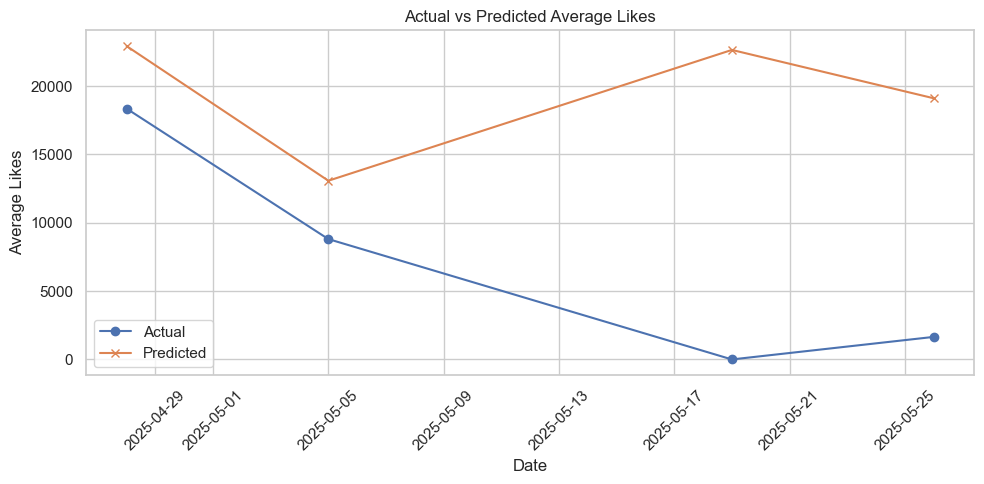

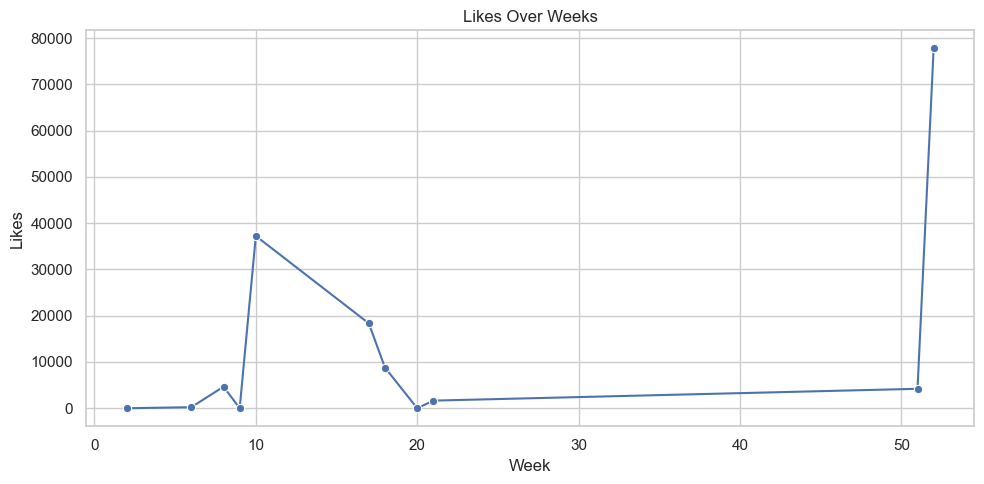

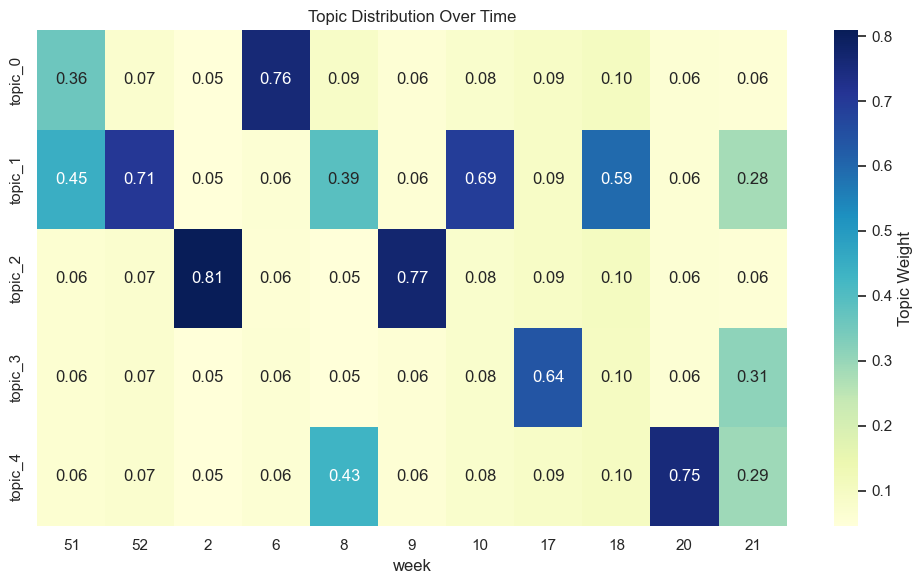

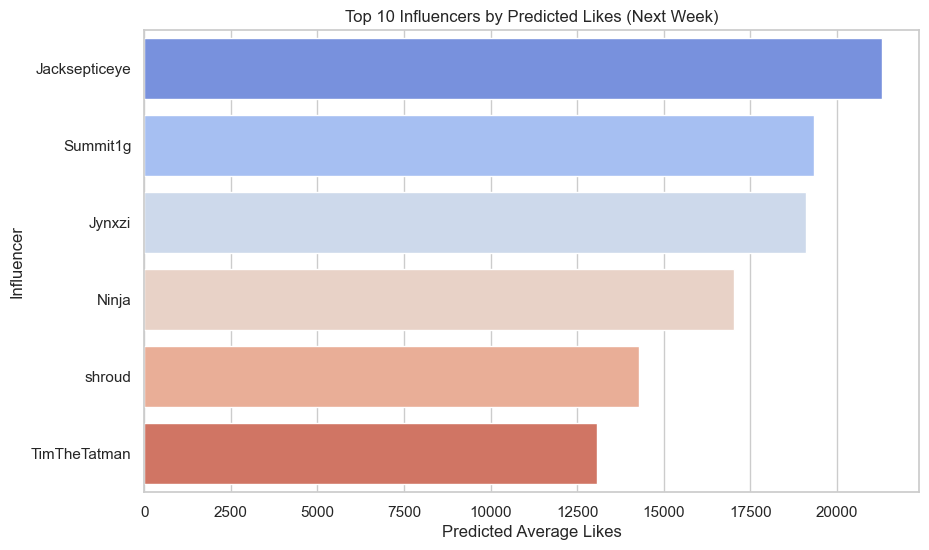

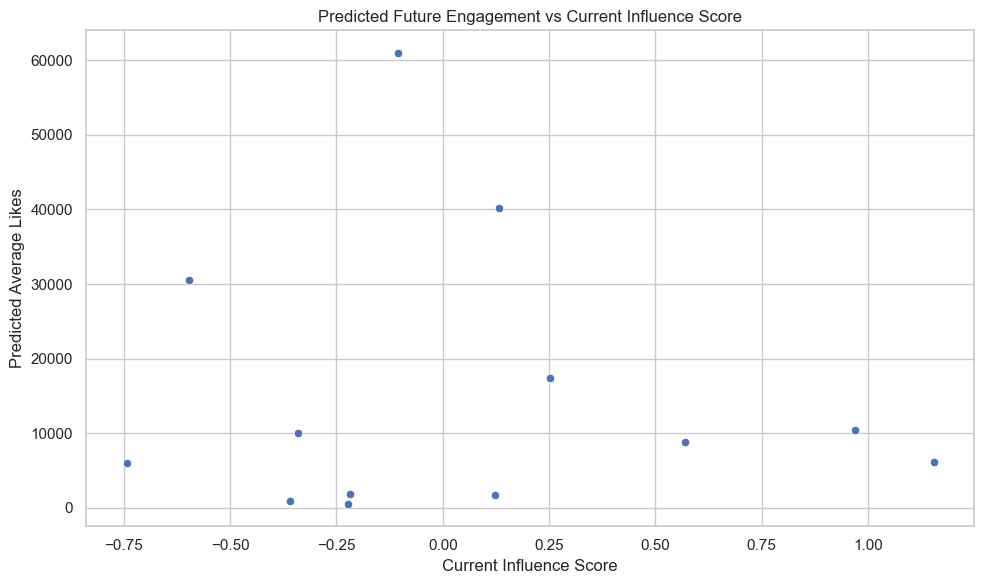

✅ Model trained to predict future engagement as a proxy for influence using real tweet data.


/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_25419/3272875693.py:139: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_25419/3272875693.py:140: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig("data/outputs/visualizations/engagement_by_hour.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


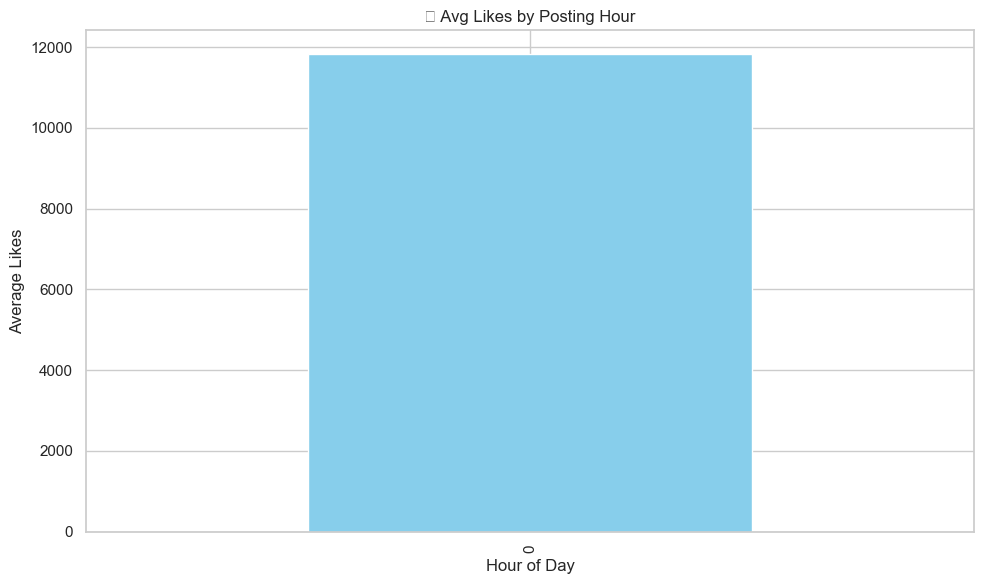

🕒 Best posting hour based on avg likes: 0:00


/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_25419/3272875693.py:153: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_25419/3272875693.py:154: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


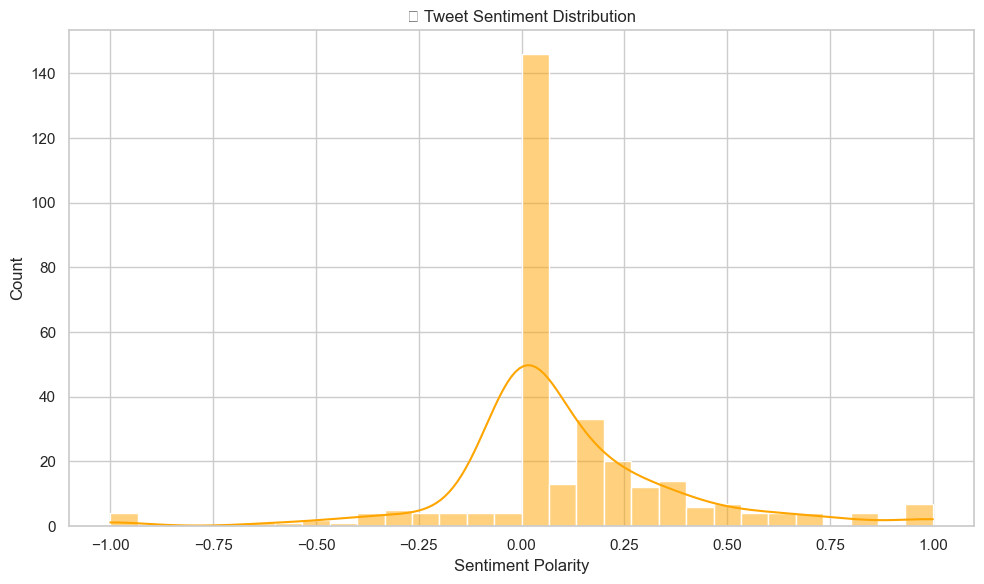

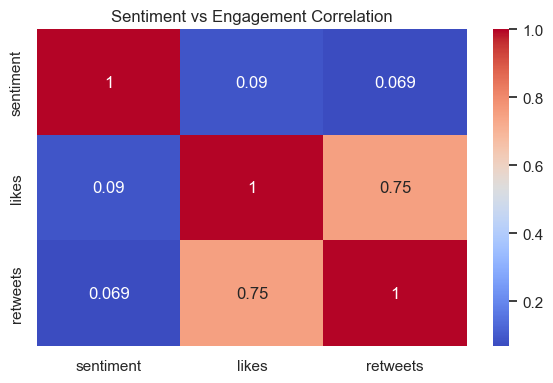

<Figure size 1000x600 with 0 Axes>

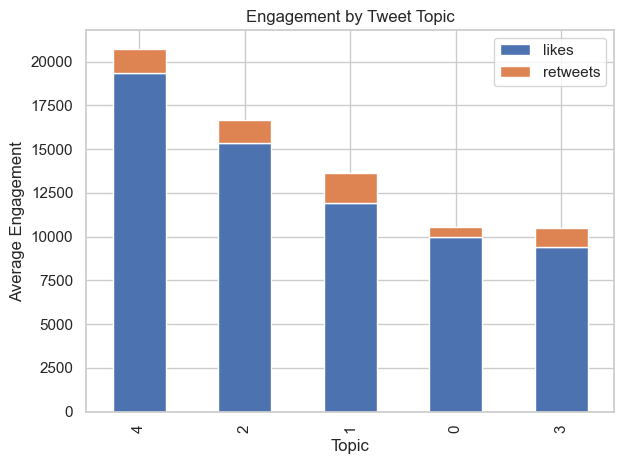


🗂 Top Keywords per Topic:
Topic 0: bxtd6meqh3, gta, chillin, rt, going, twitch, youtube, summit1g, live, https
Topic 1: optic, rt, night, stream, gonna, day, live, good, today, https
Topic 2: tomorrow, verdansk, work, safe, d7tqjildgj, fortnite, live, thank, rt, https
Topic 3: raiders, hwqufo0uxu, fortnite, love, live, day, en, time, rt, https
Topic 4: friend, 10, football, lt, running, live, ll, just, rt, https

✅ Strategy Recommendations Based on Data:
• 🕒 Optimal posting time: 0:00
• 🔥 Topics with highest average engagement:
   - Topic 4 → Avg Likes: 19326.6, Retweets: 1414.5
   - Topic 2 → Avg Likes: 15321.8, Retweets: 1337.7
   - Topic 1 → Avg Likes: 11906.6, Retweets: 1748.6
• 🧠 Sentiment correlation with likes: 0.09
• 🔁 Sentiment correlation with retweets: 0.07

📈 Feature Importances for Predicting Future Engagement:
avg_retweets_lag1         0.206217
avg_topic_4_lag1          0.205368
avg_likes_lag1            0.202317
avg_topic_0_lag1          0.083232
avg_topic_3_lag1       

In [31]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from textblob import TextBlob
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sns.set(style="whitegrid")

# ---------------------------------------
# PART A: Predict Future Influence Using Real Tweet Data
# ---------------------------------------

# Load static centrality data
df_static = pd.read_csv('data/outputs/centrality/influencer_centrality.csv')

# Load tweet data
with open('data/raw/tweets_data.json', 'r') as f:
    tweets = json.load(f)

# Process tweet data
rows = []
for user in tweets:
    username = user['username']
    instructions = user.get('tweets', {}).get('result', {}).get('timeline', {}).get('instructions', [])
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            for entry in entries:
                content = entry.get('content', {})
                item_content = content.get('itemContent', {})
                tweet_result = item_content.get('tweet_results', {}).get('result', {})
                legacy = tweet_result.get('legacy', {})
                text = legacy.get('full_text', "")
                timestamp = legacy.get('created_at', None)
                if text and timestamp:
                    try:
                        dt = datetime.strptime(timestamp, '%a %b %d %H:%M:%S %z %Y')
                        rows.append({
                            'username': username,
                            'date': dt.date(),
                            'text': text,
                            'likes': legacy.get('favorite_count', 0),
                            'retweets': legacy.get('retweet_count', 0)
                        })
                    except Exception as e:
                        print(f"Skipping tweet due to error: {e}")

df_tweets = pd.DataFrame(rows)

# Add sentiment analysis
df_tweets['sentiment'] = df_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Topic modeling
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_topics = vectorizer.fit_transform(df_tweets['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_dist = lda.fit_transform(X_topics)
for i in range(5):
    df_tweets[f'topic_{i}'] = topic_dist[:, i]

# Group by username and week
df_tweets['week'] = pd.to_datetime(df_tweets['date']).dt.to_period('W')
weekly_metrics = df_tweets.groupby(['username', 'week']).agg({
    'text': 'count',
    'likes': ['sum', 'mean'],
    'retweets': ['sum', 'mean'],
    'sentiment': 'mean',
    'topic_0': 'mean',
    'topic_1': 'mean',
    'topic_2': 'mean',
    'topic_3': 'mean',
    'topic_4': 'mean'
}).reset_index()
weekly_metrics.columns = ['username', 'week', 'num_tweets', 'total_likes', 'avg_likes', 'total_retweets', 'avg_retweets', 'avg_sentiment', 'avg_topic_0', 'avg_topic_1', 'avg_topic_2', 'avg_topic_3', 'avg_topic_4']

# Add lagged features
for col in ['avg_likes', 'avg_retweets', 'avg_sentiment', 'avg_topic_0', 'avg_topic_1', 'avg_topic_2', 'avg_topic_3', 'avg_topic_4']:
    weekly_metrics[f'{col}_lag1'] = weekly_metrics.groupby('username')[col].shift(1)

# Merge with centrality metrics
weekly_metrics = weekly_metrics.merge(df_static[['screen_name', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']], 
                                      left_on='username', right_on='screen_name', how='left')
weekly_metrics.drop('screen_name', axis=1, inplace=True)

# Prepare modeling data
model_df = weekly_metrics.dropna(subset=[f'{col}_lag1' for col in ['avg_likes', 'avg_retweets', 'avg_sentiment', 'avg_topic_0', 'avg_topic_1', 'avg_topic_2', 'avg_topic_3', 'avg_topic_4']])
features = ['avg_likes_lag1', 'avg_retweets_lag1', 'avg_sentiment_lag1', 'avg_topic_0_lag1', 'avg_topic_1_lag1', 'avg_topic_2_lag1', 'avg_topic_3_lag1', 'avg_topic_4_lag1', 
            'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
target = 'avg_likes'
X = model_df[features]
y = model_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"📊 Mean Squared Error on Test Set: {mse:.4f}")

# Predict future engagement
last_rows = weekly_metrics.groupby('username').last().reset_index()
X_pred = last_rows[features]
future_predictions = model.predict(X_pred)
last_rows['predicted_avg_likes'] = future_predictions

# Visualize predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='influencer_score', y='predicted_avg_likes', data=last_rows.merge(df_static, left_on='username', right_on='screen_name'))
plt.title('Predicted Future Engagement vs Current Influence Score')
plt.xlabel('Current Influence Score')
plt.ylabel('Predicted Average Likes')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/predicted_engagement_vs_influence.png', dpi=300)
plt.show()

print("✅ Model trained to predict future engagement as a proxy for influence using real tweet data.")

# ---------------------------------------
# PART B: Optimal Posting Time
# ---------------------------------------

df_tweets['hour'] = pd.to_datetime(df_tweets['date']).dt.hour
hourly_likes = df_tweets.groupby('hour')['likes'].mean()
best_hour = hourly_likes.idxmax()

plt.figure(figsize=(10, 6))
hourly_likes.plot(kind='bar', color='skyblue')
plt.title("📈 Avg Likes by Posting Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Likes")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_hour.png", dpi=300)
plt.show()

print(f"🕒 Best posting hour based on avg likes: {best_hour}:00")

# ---------------------------------------
# PART C: Sentiment Analysis
# ---------------------------------------

plt.figure(figsize=(10, 6))
sns.histplot(df_tweets['sentiment'], bins=30, kde=True, color='orange')
plt.title("🧠 Tweet Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
plt.show()

sentiment_corr = df_tweets[['sentiment', 'likes', 'retweets']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_corr, annot=True, cmap='coolwarm')
plt.title("Sentiment vs Engagement Correlation")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_engagement_correlation.png", dpi=300)
plt.show()

# ---------------------------------------
# PART D: Topic Modeling & Engagement
# ---------------------------------------

df_tweets['topic'] = lda.transform(X_topics).argmax(axis=1)
topic_engagement = df_tweets.groupby('topic')[['likes', 'retweets']].mean().sort_values(by='likes', ascending=False)

plt.figure(figsize=(10, 6))
topic_engagement.plot(kind='bar', stacked=True)
plt.title("Engagement by Tweet Topic")
plt.xlabel("Topic")
plt.ylabel("Average Engagement")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_topic.png", dpi=300)
plt.show()

print("\n🗂 Top Keywords per Topic:")
for idx, topic in enumerate(lda.components_):
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx}: {', '.join(top_keywords)}")

# ---------------------------------------
# PART E: Strategy Recommendations
# ---------------------------------------

print("\n✅ Strategy Recommendations Based on Data:")
print(f"• 🕒 Optimal posting time: {best_hour}:00")

print("• 🔥 Topics with highest average engagement:")
top_topics = topic_engagement.head(3)
for i, row in top_topics.iterrows():
    print(f"   - Topic {i} → Avg Likes: {row['likes']:.1f}, Retweets: {row['retweets']:.1f}")

print("• 🧠 Sentiment correlation with likes: {:.2f}".format(sentiment_corr.loc['sentiment', 'likes']))
print("• 🔁 Sentiment correlation with retweets: {:.2f}".format(sentiment_corr.loc['sentiment', 'retweets']))

# Feature importance analysis
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\n📈 Feature Importances for Predicting Future Engagement:")
print(feature_importance)

### Run Streamlit

In [ ]:
import os
os.system("python -m streamlit run app.py ")